In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import os, sys
import pandas as pd

root = '/usr/local/serenceslab/maggie/shapeDim/'

sys.path.append(os.path.join(root, 'Analysis'))
from code_utils import file_utils, data_utils
from code_utils import stats_utils, plot_utils


In [2]:
task_names = ['Linear (1)','Linear (2)','Checker', 'Repeat'];
n_tasks = len(task_names)
task_colors = np.flipud(cm.GnBu(np.linspace(0,1,5))[1:,:])

n_subjects = 7
subjects = np.arange(1,8)
subcolors = cm.Dark2(np.linspace(0,1,n_subjects))

In [3]:
lab = dict()
for ss in subjects:
    
    # get labels for all the trials, this subject
    main_labels = data_utils.load_main_task_labels(ss)
    rep_labels = data_utils.load_repeat_task_labels(ss)
    lab[ss] = pd.concat([main_labels, rep_labels], axis=0)
   

In [4]:
from code_utils import grid_utils
grid_pts = grid_utils.get_main_grid()
# NOTE i am swapping the columns here
# because this is the order you get from doing np.unique(pts)
# this is the actual order that the predictions 1-16 of this classifier
# correspond to. 
grid_pts = grid_pts[:,[1,0]] 

In [5]:
save_folder = os.path.join(root, 'Analysis', 'decoding_results')
save_filename = os.path.join(save_folder, 'decode_multiclass_withintask.npy')
dec_withintask = np.load(save_filename, allow_pickle=True).item()
dec_withintask.keys()
roi_names = dec_withintask['roi_names']
roi_names[-1] = 'IPS'
n_rois = len(roi_names)

#### compute Checker Task accuracy for different sets of trials
far, Med, near are all in main grid, different positions relative to boundaries


In [6]:
n_tasks = 3

conf_fartrials = np.zeros((n_subjects, n_rois, n_tasks, 1))
dprime_fartrials = np.zeros((n_subjects, n_rois, n_tasks, 1))
acc_fartrials = np.zeros((n_subjects, n_rois, n_tasks, 1))

conf_midtrials = np.zeros((n_subjects, n_rois, n_tasks, 1))
dprime_midtrials = np.zeros((n_subjects, n_rois, n_tasks, 1))
acc_midtrials = np.zeros((n_subjects, n_rois, n_tasks, 1))

ii = 0;

for si, ss in enumerate(subjects):

    for ti, tt in enumerate([1,2,3]):
        
        l = lab[ss][lab[ss]['task']==tt]
        
        pt_labs = np.array([l['ptx'], l['pty']]).T
        
        is_main_grid = l['is_main_grid']==1
        
        dist = l['dist_from_bound3'].round(2)
        
        categ_actual = np.array(l['categ_task3']).astype(int)
        
        un_dist = np.unique(dist[is_main_grid])
        
        is_middle = is_main_grid & (dist==0.8)
        is_far = is_main_grid & (dist==2.4)
        
        correct = np.array(l['subject_correct'])
        
        for ri in range(n_rois):

            pred = dec_withintask['preds_all'][si][ri][ti].astype(int)

            coords_pred = grid_pts[pred,:]
            categ_pred = grid_utils.get_categ(coords_pred, 3)
            
            prob = dec_withintask['probs_all'][si][ri][ti]

            # "confidence" in assignment to category 2 vs 1
            # group the 16 points into categories w/r/t relevant axis
            g1 = grid_utils.get_categ(grid_pts, 3)==1
            p_categ1 = np.sum(prob[:,g1], axis=1)
            g2 = grid_utils.get_categ(grid_pts, 3)==2
            p_categ2 = np.sum(prob[:,g2], axis=1)

            # signed confidence will be: p(correct) - p(incorrect)
            signedconf = np.zeros_like(p_categ1)
            signedconf[categ_actual==1] = p_categ1[categ_actual==1] - p_categ2[categ_actual==1]
            signedconf[categ_actual==2] = p_categ2[categ_actual==2] - p_categ1[categ_actual==2]

            # far trials
            inds = is_far & correct

            conf_fartrials[si,ri,ti,ii] = np.mean(signedconf[inds])

            d = stats_utils.get_dprime(categ_pred[inds], categ_actual[inds])
            dprime_fartrials[si,ri,ti,ii] = d;

            acc_fartrials[si,ri,ti,ii] = np.mean(categ_pred[inds]==categ_actual[inds])

            # middle trials
            inds = is_middle & correct

            conf_midtrials[si,ri,ti,ii] = np.mean(signedconf[inds])

            d = stats_utils.get_dprime(categ_pred[inds], categ_actual[inds])
            dprime_midtrials[si,ri,ti,ii] = d;

            acc_midtrials[si,ri,ti,ii] = np.mean(categ_pred[inds]==categ_actual[inds])


#### Get confidence for nearest trials

For the nearest trials, the average confidence values are generated by resampling 
the center grid trials so that the distribution of stims is more even across tasks.

this is done in bootstrap_confidence.py (i saved it to disk because it takes ~10 minutes to run)

In [12]:
from multinomial_decoding import bootstrap_confidence
# bootstrap_confidence.bootstrap_binary_hardtrials_include_checker(n_boot_iter=1000)

In [7]:
save_folder = os.path.join(root, 'Analysis', 'decoding_results')
fn2load = os.path.join(save_folder, 'decode_multiclass_binary_hardtrials_include_checker_bootstrap_correctonly.npy')

print(fn2load)

b = np.load(fn2load, allow_pickle=True).item()
b.keys()
signedconf_neartrials_boot = b['signedconf_hardtrials_boot']

conf_neartrials = np.mean(signedconf_neartrials_boot[:,:,:,2:3,:], axis=4)


/usr/local/serenceslab/maggie/shapeDim/Analysis/decoding_results/decode_multiclass_binary_hardtrials_include_checker_bootstrap_correctonly.npy


In [8]:
plt.rcParams['pdf.fonttype']=42
plot_utils.set_all_font_sizes(fs = 16)
figfolder = os.path.join(root, 'Analysis','figures')

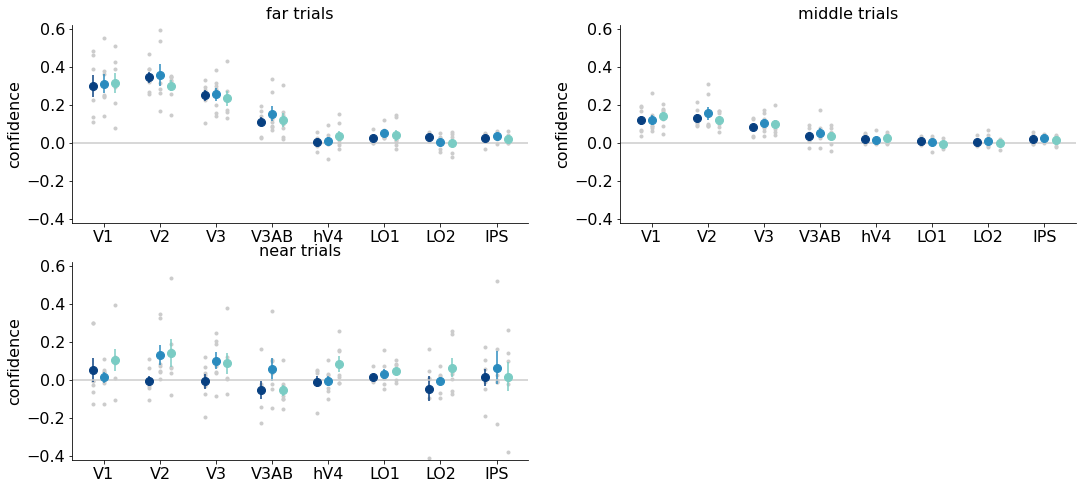

In [9]:
ti_plot = [0,1,2]

plt.figure(figsize=(18,8))

x_jitter = np.linspace(-0.2, 0.2, 3)

pi=0

for rvals, name in zip([conf_fartrials, conf_midtrials, conf_neartrials,], \
                     ['far trials','middle trials', 'near trials']):

    pi+=1
    ax = plt.subplot(2,2,pi)
    plt.axhline(0, color=[0.8, 0.8, 0.8])

    lh = []

    for ti in ti_plot:

        x_ticks = np.arange(n_rois) + x_jitter[ti]

        vals = rvals[:,:,ti,ii]
        meanvals = np.mean(vals, axis=0)
        semvals = np.std(vals, axis=0)/np.sqrt(n_subjects-1)

        plt.plot(x_ticks, meanvals, 'o', color=task_colors[ti], alpha=1, \
                     markersize=8)
        h = plt.errorbar(x_ticks, meanvals, semvals, xerr=None, color=task_colors[ti], linestyle='none')
        lh.append(h)
        
    for ri in range(n_rois):
        
        plt.plot(ri+x_jitter, rvals[:,ri,ti_plot,ii].T, '.', color=[0.8, 0.8,0.8], zorder=-10)

    ylims = [-0.42, 0.62]
    # ylims = [-0.2, 0.6]
    assert(np.all(rvals[:,:,ti_plot,:]>ylims[0]))
    assert(np.all(rvals[:,:,ti_plot,:]<ylims[1]))
    plt.ylim(ylims)

    plt.xticks(np.arange(n_rois), roi_names)
    plt.ylabel('confidence')

    # plt.legend(lh,np.array(task_names)[ti_plot])
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.title(name)

    # plt.suptitle('confidence for predicting correct checker category (2-way) - %s'%name)

    figname = os.path.join(figfolder, 'checker_confidence.pdf')
    plt.savefig(figname)

In [18]:
for rvals, diffname in zip([conf_fartrials, conf_midtrials, conf_neartrials], \
                     ['far','middle','near']):

    vals = rvals[:,:,:,0]

    anova_result = stats_utils.rmanova_2way(vals, ['ROI','Task'], 
                                                do_shuffle=True, n_iter=10000, rndseed = 868679)

    anova_result['Pr > F'] = anova_result['Pr > F'].round(4)

    tablename = os.path.join(figfolder, 'checker_rm_anova_%s.csv'%(diffname))
    
    print(tablename)
    anova_result.to_csv(tablename)


/usr/local/serenceslab/maggie/shapeDim/Analysis/figures/checker_rm_anova_far.csv
/usr/local/serenceslab/maggie/shapeDim/Analysis/figures/checker_rm_anova_middle.csv
/usr/local/serenceslab/maggie/shapeDim/Analysis/figures/checker_rm_anova_near.csv


In [10]:
for diffname in ['far','middle','near']:
    
    tablename = os.path.join(figfolder, 'checker_rm_anova_%s.csv'%(diffname))
    anova_result = pd.read_csv(tablename, index_col=0)
    print('\nAnova for Checker confidence, %s trials'%(diffname))
    
    print(anova_result)


Anova for Checker confidence, far trials
            F Value  Num DF  Den DF  Pr > F  p (permutation)
ROI       42.190647     7.0    42.0  0.0000           0.0000
Task       0.534460     2.0    12.0  0.5993           0.6034
ROI:Task   0.596872    14.0    84.0  0.8604           0.8692

Anova for Checker confidence, middle trials
            F Value  Num DF  Den DF  Pr > F  p (permutation)
ROI       22.249921     7.0    42.0   0.000           0.0000
Task       0.739203     2.0    12.0   0.498           0.5073
ROI:Task   0.778586    14.0    84.0   0.689           0.7015

Anova for Checker confidence, near trials
           F Value  Num DF  Den DF  Pr > F  p (permutation)
ROI       2.245077     7.0    42.0  0.0493           0.0480
Task      1.346464     2.0    12.0  0.2968           0.3123
ROI:Task  0.829688    14.0    84.0  0.6354           0.6414
